In [1]:
from pylab import *
import pandas as pd
from energydiagram import ED
from matplotlib.gridspec import GridSpec

import os, sys
sys.path.append(os.path.abspath('../function_files/'))
from energy_dia import build_diagram, fig_settings

# Constants

In [2]:
# define constant parameters
# surfaces
surfs = ['Pt100', 'Pt110', 'Pt111', 'Ru0001']
# potentials vs. RHE
Us = linspace(-1,0.5,4)
# elementary charge
ec = 1.6e-19 # C
# convert J to eV
conv = 1.6e-19 # J/eV

In [3]:
states = ['ref', 'FF*','(FF+H)*','FA*',
                      '(FA+H)*','(FA+2H)*','(FA+3H)*','THFA*','THFA(g)']

In [4]:
# create labels and list of colors for plots
U_label = []
U_colors = []
for i,U in enumerate(Us):
    U_label.append(f'{U} V vs. RHE')
    U_colors.append(f'C{i}')

# Import Data

In [5]:
# set G ref
# collect surface energies
surf_files = ['Pt100/platinum', 'Pt110/platinum',
              'Pt111/platinum', 'Ru0001/ruthenium']
surf_es = []
for i,s in enumerate(surf_files):
    data = pd.read_csv(f'../data/DFT_Es/surface/{s}_energy.csv')
    data.set_index('metric', inplace=True)
    surf_es += [data.loc['Converged Energy / eV']['value']]

# import gas phase data
FFgas = pd.read_csv('../data/Free_Energies/FF_molecs_gas_Gsummary_20C.csv')

# get gas phase G for FF, 4PP, and H2
G_FF = FFgas['G/eV'].iloc[0]
G_H2 = FFgas['G/eV'].iloc[-1]

# G_ref_FF = G_FF(g) + 3G_H2(g) + E_surf
G_ref_FF = surf_es + 3*G_H2 + G_FF

In [6]:
# FF pathway data
# compile Gi - Gref
# Gi = G(i) + nH2*G_H2(g) - Gref
# nH2 is the number of gas phase H2 molecules to add

nH2 = array([3, 2.5, 2, 1.5, 1, 0.5, 0])
rxnG = []

for i,s in enumerate(surfs):
    data = pd.read_csv(f'../data/Free_Energies/FFmolecs_{s}_Gsummary_20C.csv')
    # gather all ads state Gs
    Gi = array(data['G/eV'].iloc[:7])
    # surface energy
    Es = surf_es[i]
    # desorption of THFA
    THFAg = FFgas['G/eV'].iloc[2]
    # calculate Delta G
    # add a zero at the beginning of the array to represent ref state
    dG = append([0], Gi + nH2*G_H2 - G_ref_FF[i])
    dG = append(dG, [THFAg + Es - G_ref_FF[i]])
    rxnG += [dG] 

# Calculate Potential Dependent State Free Energy

In [7]:
# create array with copies of unbiased energies for each potential of interest
# shape indices are (Potential, Surface, State)
PDE = array([rxnG.copy()]*len(Us))

# define the number of electrons used for each step
# reference state does not use electrons
n = append([0,0],arange(1,7))
n = append(n,6)

# update the state energies with potential dependance for THFA path
for i,a in enumerate(PDE):
    for j,g in enumerate(a):
        # Gi(U) (eV) = Gi(U0) + n|e|U
        PDE[i,j] = array(g) + n * ec * Us[i] / conv 

In [8]:
# reorganize data by facet
PD_100 = []
PD_110 = []
PD_111 = []
PD_Ru = []
for i,p in enumerate(PDE):
    PD_100.append(p[0])
    PD_110.append(p[1])
    PD_111.append(p[2])
    PD_Ru.append(p[3])

PD_surfs = [PD_100, PD_110, PD_111, PD_Ru]

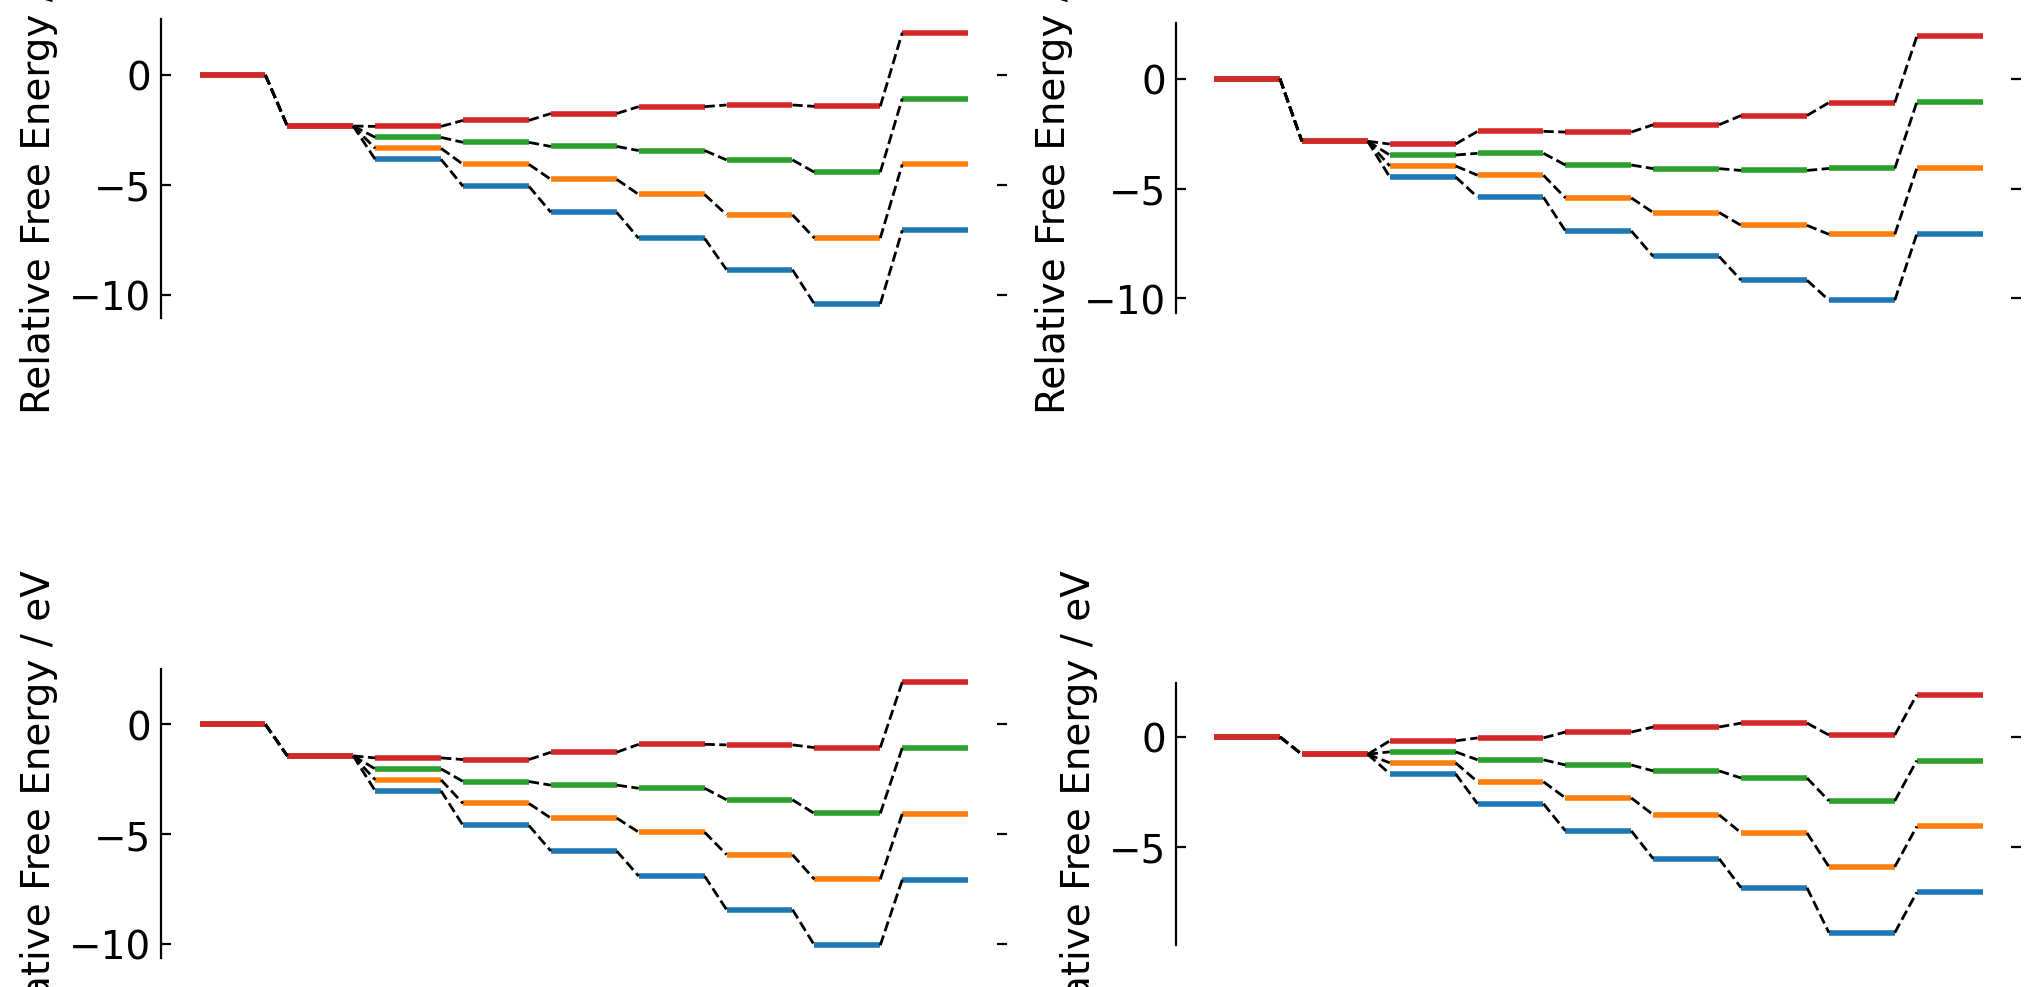

In [9]:
# build initial diagrams
fig = figure(figsize=(12,8))

gs = GridSpec(2, 2, height_ratios=[1,1], width_ratios=[1,1], wspace=0.2, hspace =0.1)
axs = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1]),
       fig.add_subplot(gs[2]), fig.add_subplot(gs[3])]

dias = []
for i,d in enumerate(PD_surfs):
    dias.append(build_diagram(d, states, U_colors, axs[i]))

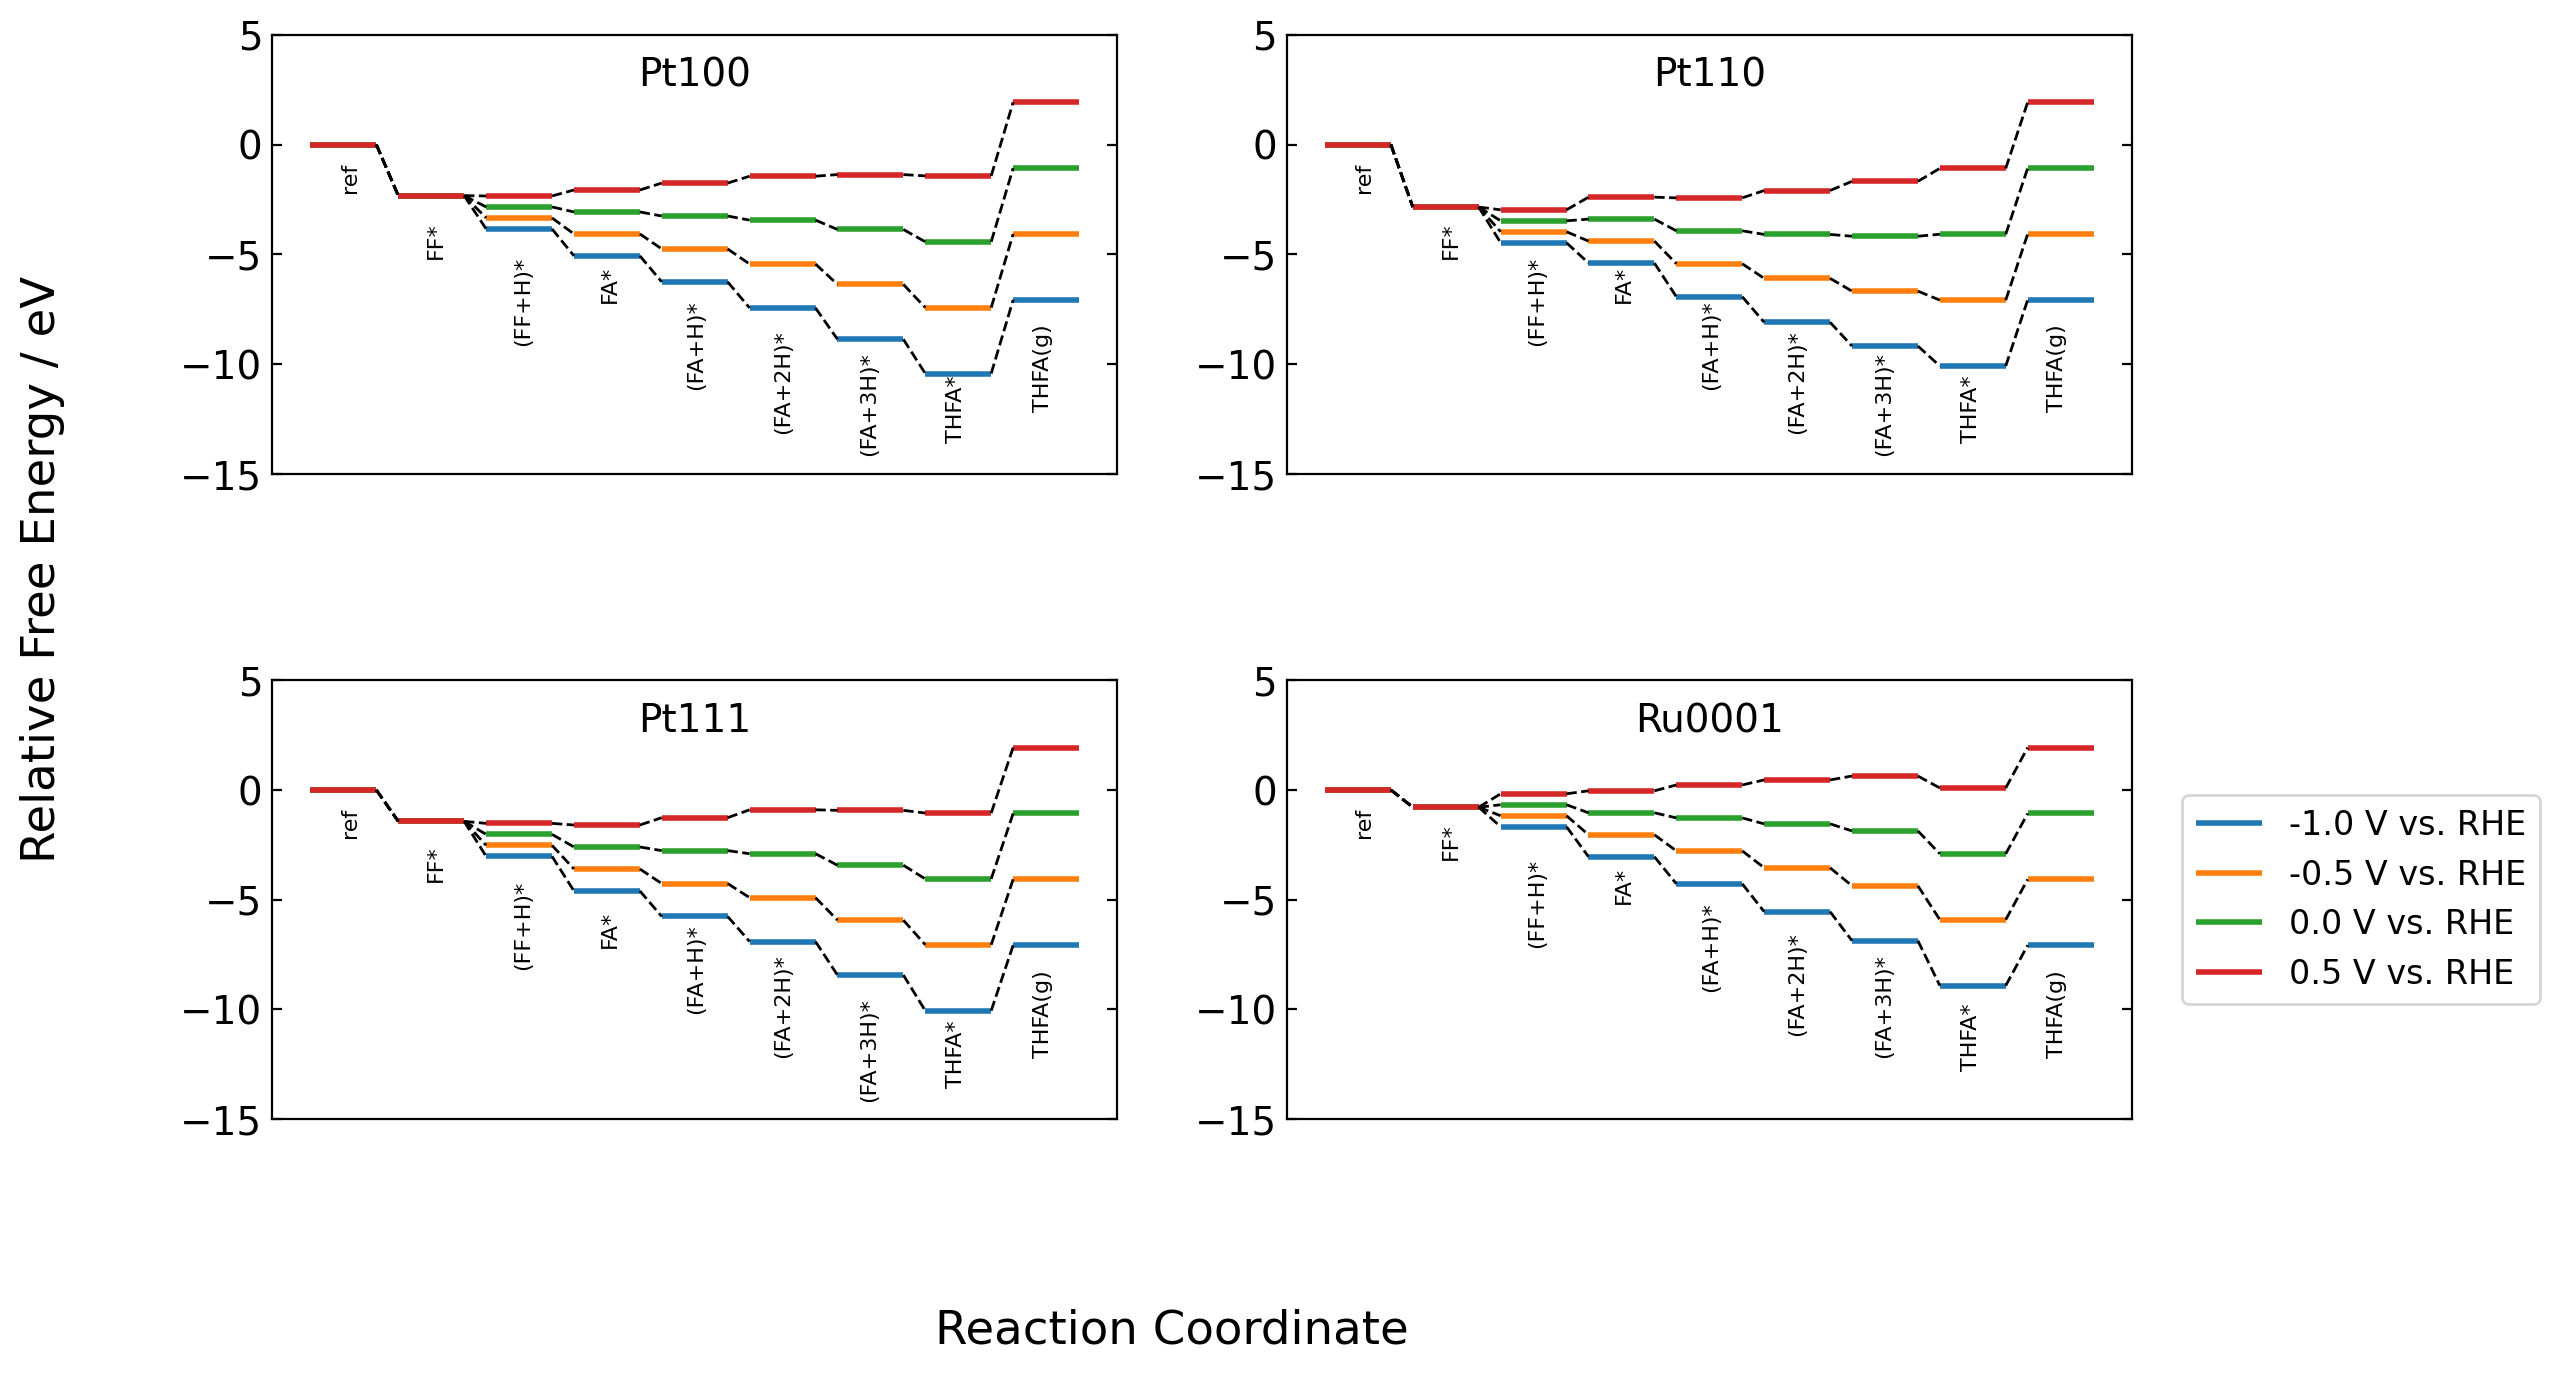

In [10]:
# format diagrams
up = 5
lo = -15
ylims = [(lo,up), (lo,up), (lo,up), (lo,up)]
xs = linspace(0.08, 0.9, 9)
ys = array([[0.65, 0.5, 0.3, 0.4, 0.2, 0.1, 0.05, 0.08,0.15],
        [0.65, 0.5, 0.3, 0.4, 0.2, 0.1, 0.05, 0.08,0.15],
        [0.65, 0.55, 0.35, 0.4, 0.25, 0.15, 0.05, 0.08,0.15],
        [0.65, 0.6, 0.4, 0.5, 0.3, 0.2, 0.15, 0.12,0.15]])

dias[-1].ax.legend(U_label, bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize = 12)
for i,d in enumerate(dias):
    fig_settings(d, ylims[i], U_label, surfs[i], states, 8, xs, ys[i])
    d.ax.set_xlabel(" ")
    d.ax.set_ylabel(" ")

fig.supxlabel('Reaction Coordinate')
fig.supylabel('Relative Free Energy / eV')
fig